因子就是价格，分析的结果就是用于指导我们：买股票的时候是买便宜的股票还是买贵的股票更占优势？即价格便宜的股票相对于价格贵的股票是否具有超额收益。

策略逻辑说明

这个策略和其他策略也非常相似，只是挑选股票的因子换成了价格，把股票按照价格高低排序为10组，做多价格最低的一组，做空价格最高的一组。

和前几个策略的资金、资金分配、交易手续费都是一样的。

我们使用全市场的A股日data_folder进行测试，做多头，也做空头。多头和空头都占用资金。

假设初始资金有1个亿，手续费为万分之二。

加载data_folder完毕
2005-01-04, total_value : 100000000.0
2005-01-05, total_value : 100000000.0
2005-01-06, total_value : 100000000.0
2005-01-07, total_value : 100000000.0
2005-01-10, total_value : 100000000.0
2005-01-11, total_value : 100000000.0
2005-01-12, total_value : 100000000.0
2005-01-13, total_value : 100000000.0
2005-01-14, total_value : 100000000.0
2005-01-17, total_value : 100000000.0
2005-01-18, total_value : 100000000.0
2005-01-19, total_value : 100000000.0
2005-01-20, total_value : 100000000.0
2005-01-21, total_value : 100000000.0
2005-01-24, total_value : 100000000.0
2005-01-25, total_value : 100000000.0
2005-01-26, total_value : 100000000.0
2005-01-27, total_value : 100000000.0
2005-01-28, total_value : 100000000.0
2005-01-31, total_value : 100000000.0
2005-02-01, total_value : 100000000.0
2005-02-02, total_value : 100000000.0
2005-02-03, total_value : 100000000.0
2005-02-04, total_value : 100000000.0
2005-02-16, total_value : 100000000.0
2005-02-17, total_value : 10000000

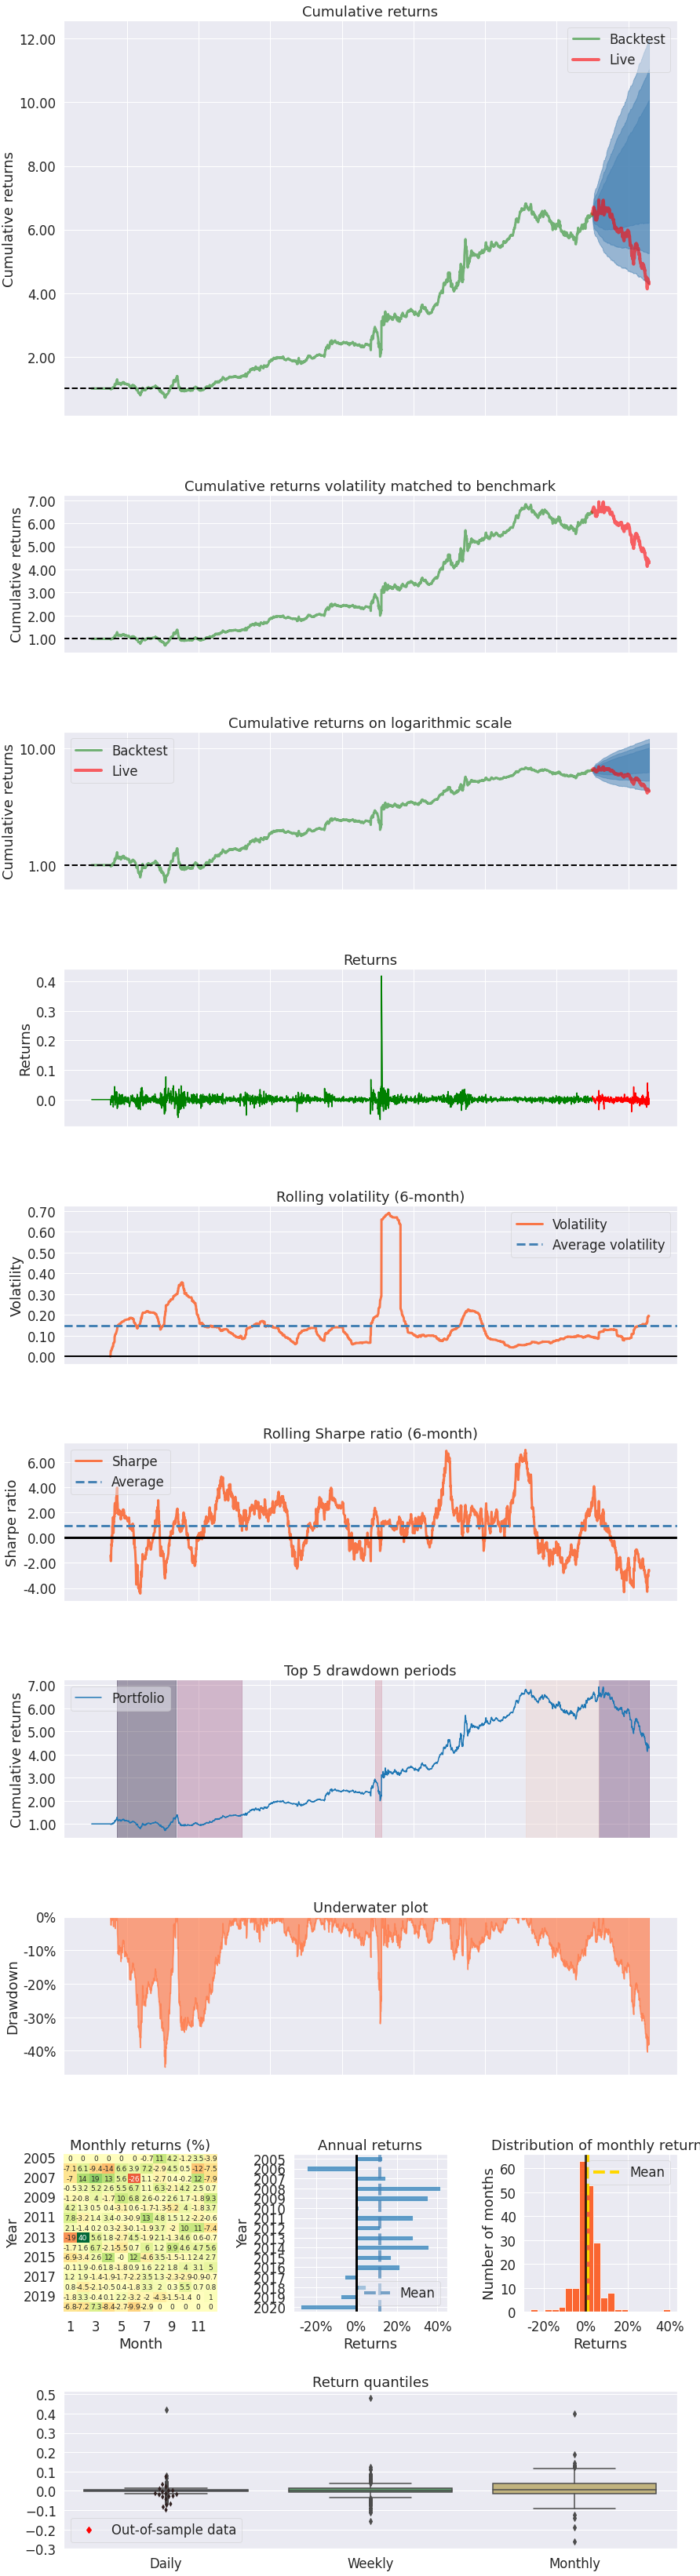

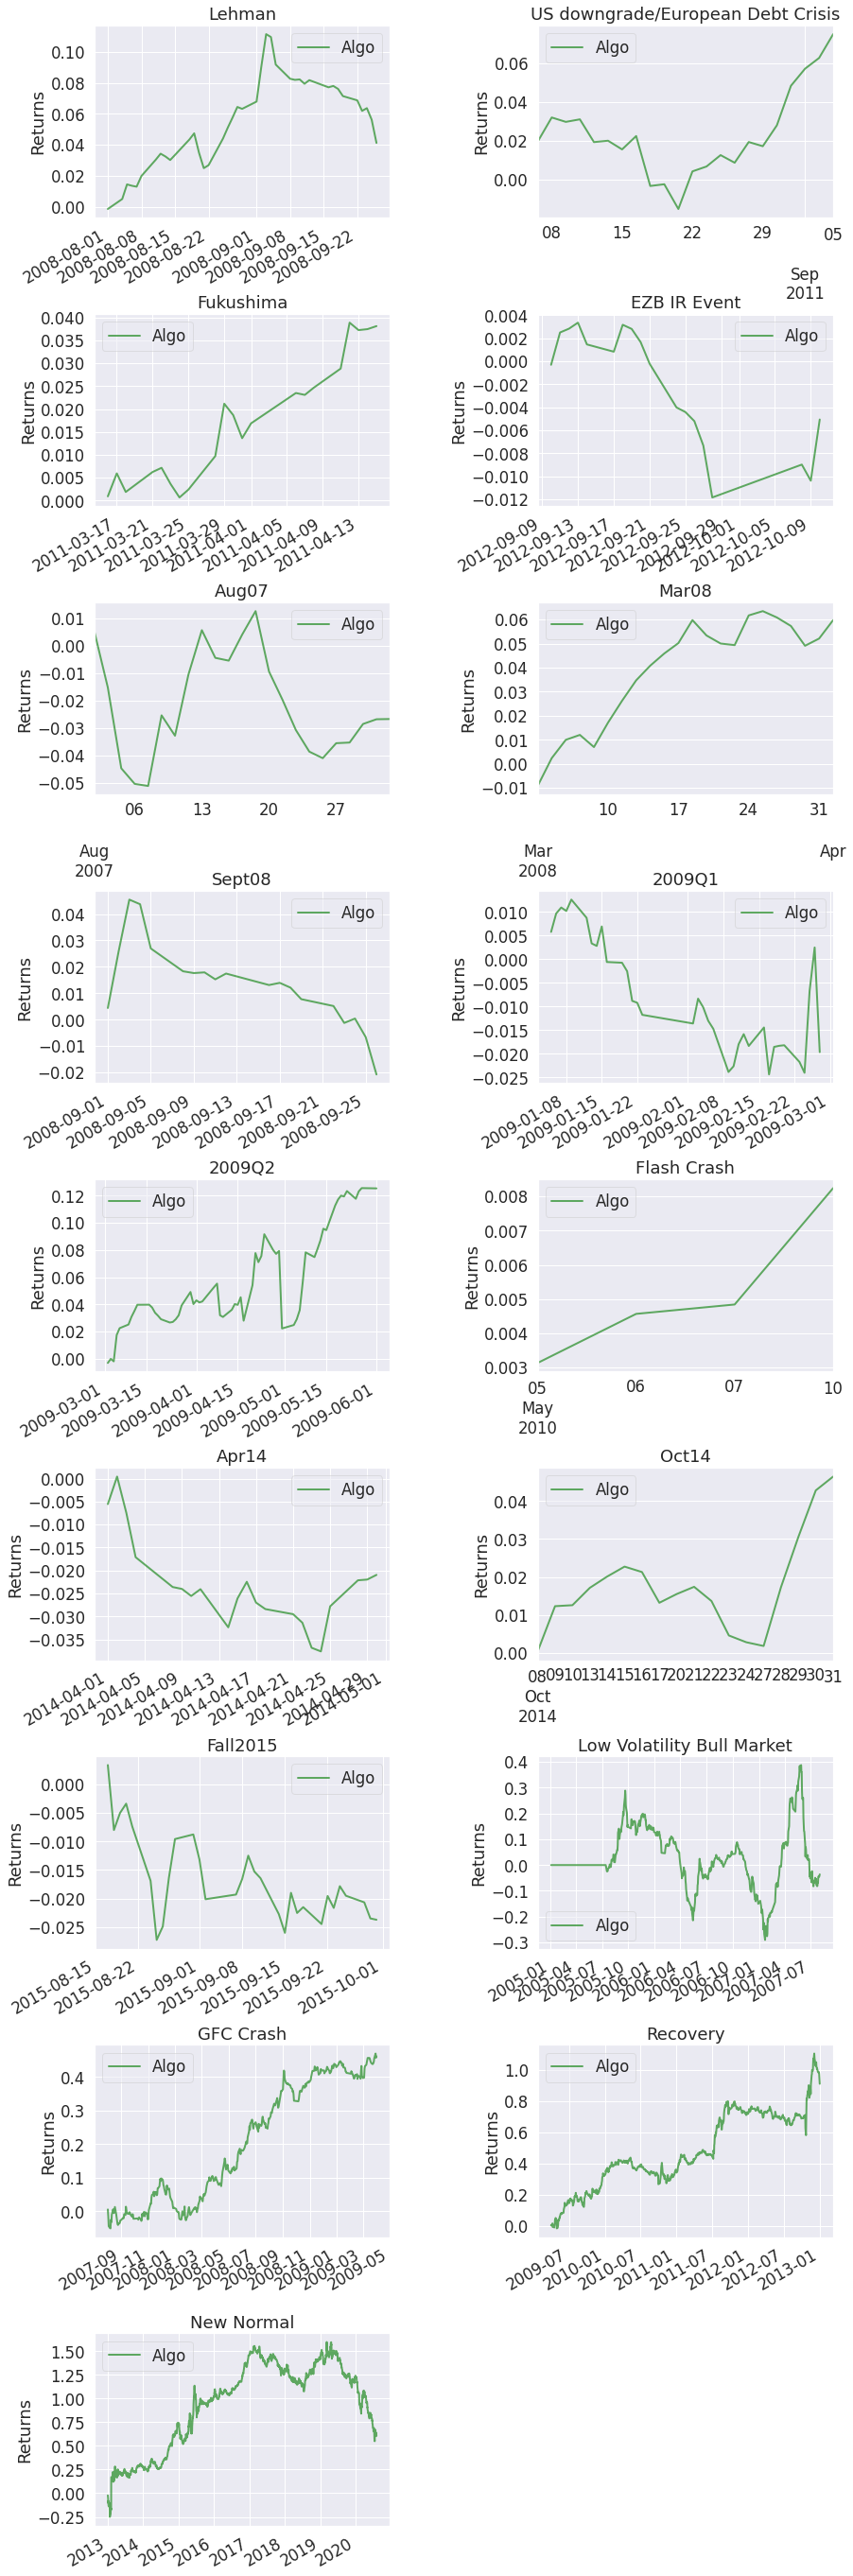

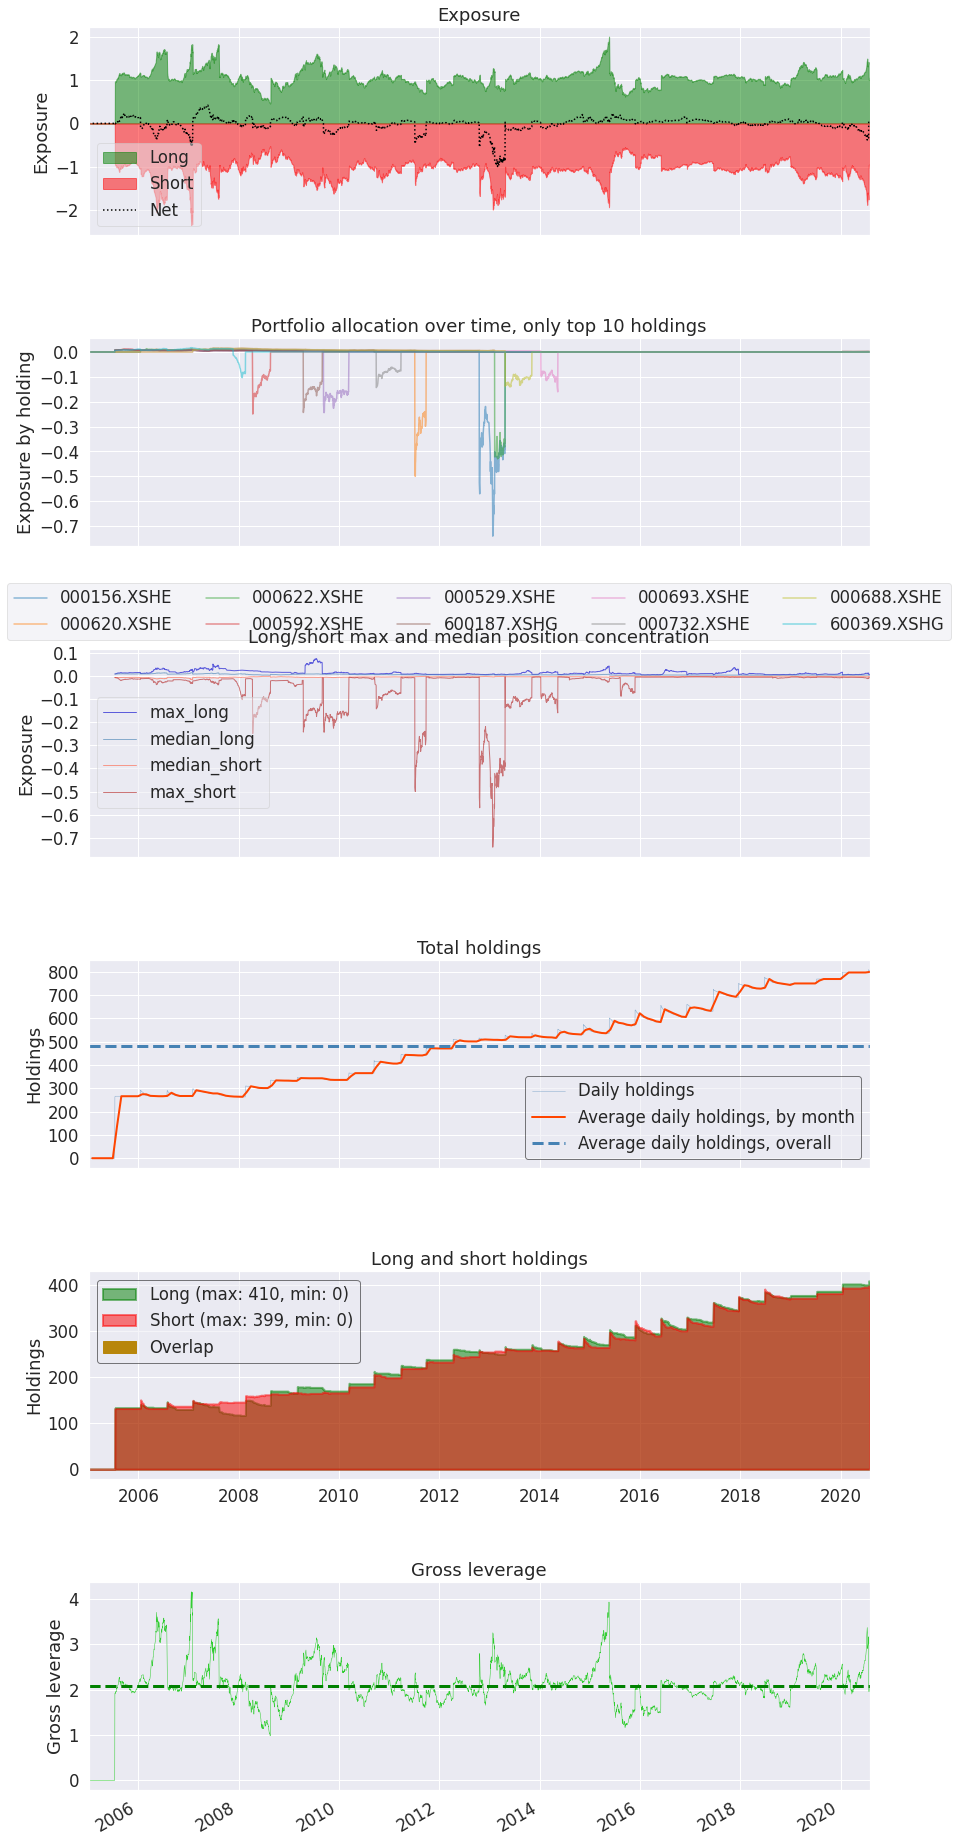

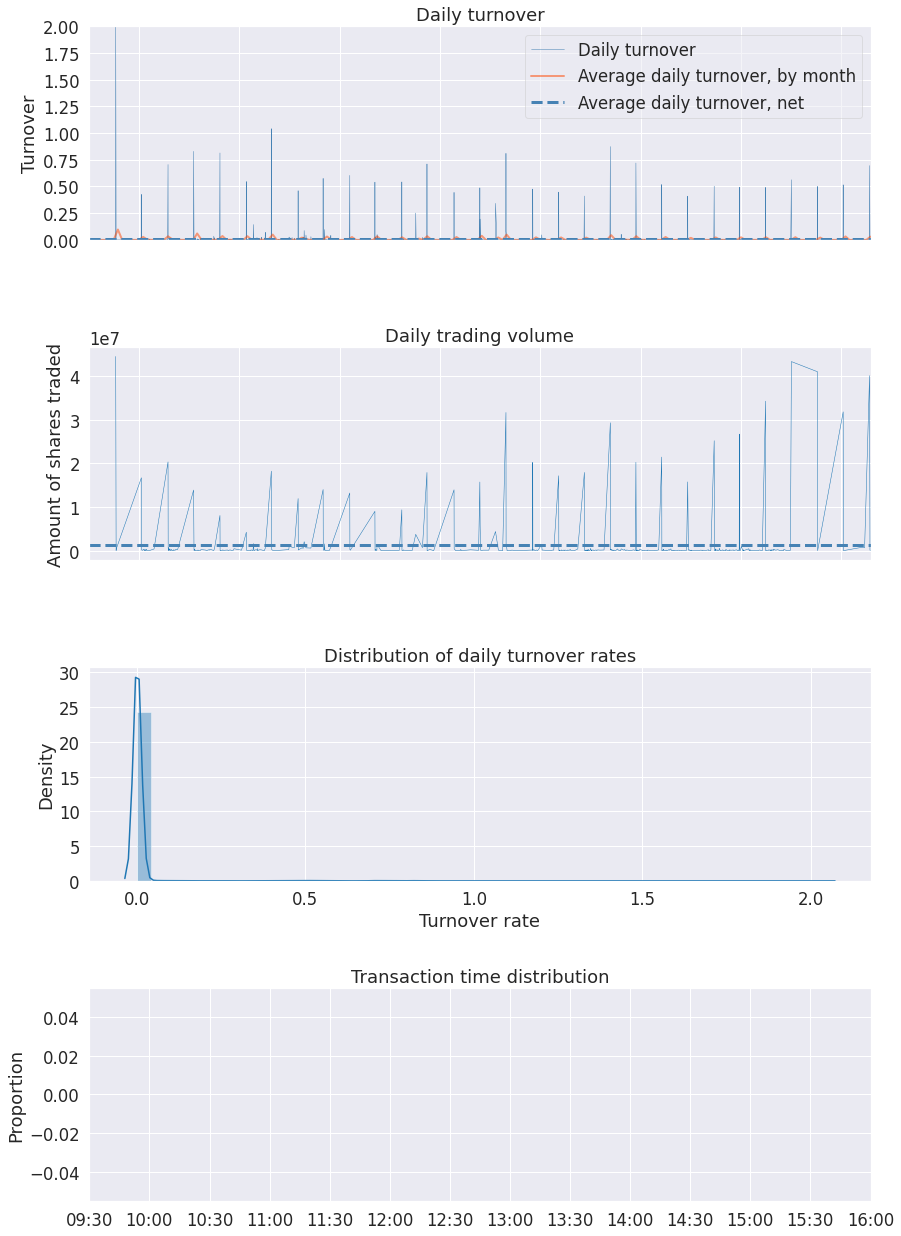

In [1]:
import backtesting as bt
import datetime
import pandas as pd
import numpy as np
import os,sys
import copy
import talib
import math 
import warnings
warnings.filterwarnings("ignore")
import pyfolio as pf

# 我们使用的时候，直接用我们新的类读取data_folder就可以了。
class test_two_ma_strategy(bt.Strategy):
   
    params = (('period',126),
              ('hold_percent',0.1)
             )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.bar_num=0    
        # 保存现有持仓的股票
        self.position_dict={}
        # 当前有交易的股票
        self.stock_dict={}
               
    def prenext(self):
        
        self.next()
        
        
    def next(self):
        # 假设有100万资金，每次成份股调整，每个股票使用1万元
        self.bar_num+=1
        # 前一交易日和当前的交易日
        pre_date = self.datas[0].datetime.date(-1).strftime("%Y-%m-%d")
        current_date = self.datas[0].datetime.date(0).strftime("%Y-%m-%d")
        # 总的价值
        total_value = self.broker.get_value()
        total_cash  = self.broker.get_cash()
        self.log(f"total_value : {total_value}")
        # 第一个data_folder是指数，校正时间使用，不能用于交易
        # 循环所有的股票,计算股票的数目
        for data in self.datas[1:]:
            data_date = data.datetime.date(0).strftime("%Y-%m-%d")
            # 如果两个日期相等，说明股票在交易
            if current_date == data_date:
                stock_name = data._name
                if stock_name not in self.stock_dict:
                    self.stock_dict[stock_name]=1
        total_target_stock_num = len(self.stock_dict)
        # 现在持仓的股票数目
        total_holding_stock_num = len(self.position_dict)
        # 计算理论上的手数
        now_value = total_value/int(total_target_stock_num*self.p.hold_percent)
        # 如果今天是调仓日
        if self.bar_num%self.p.period == 0:
            
            # 循环股票，平掉所有的股票，计算现在可以交易的股票的累计收益率
            result = []
            for data in self.datas[1:]:
                    data_date = data.datetime.date(0).strftime("%Y-%m-%d")
                    size = self.getposition(data).size
                    # 如果有仓位
                    if size!=0:
                        self.close(data)
                        if data._name in self.position_dict:
                            self.position_dict.pop(data._name)

                    # 已经下单，但是订单没有成交
                    if data._name in self.position_dict and size==0:
                        order = self.position_dict[data._name]
                        self.cancel(order)
                        self.position_dict.pop(data._name) 
                    # 如果两个日期相等，说明股票在交易,就计算收益率，进行排序
                    if current_date == data_date:
                        result.append([data,data.close[0]])
            # 根据计算出来的价格进行排序，选出价格最低的10%的股票做多
            new_result = sorted(result,key=lambda x:x[1])
            num = int(self.p.hold_percent * total_target_stock_num)
            # 做多低pb的股票，做空高pb的股票
            buy_list = new_result[:num]
            sell_list = new_result[-num:]
            # 根据计算出来的信号，买卖相应的股票
            for data,cumsum_rate in buy_list:
                lots = now_value/data.close[0]
                lots = int(lots/100)*100 # 计算能下的手数，取整数
                order = self.buy(data,size = lots)
                self.position_dict[data._name] = order
            for data,cumsum_rate in sell_list:
                lots = now_value/data.close[0]
                lots = int(lots/100)*100 # 计算能下的手数，取整数
                order = self.sell(data,size = lots)
                self.position_dict[data._name] = order
                  
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status == order.Rejected:
            self.log(f"Rejected : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Margin:
            self.log(f"Margin : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Cancelled:
            self.log(f"Concelled : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Partial:
            self.log(f"Partial : order_ref:{order.ref}  data_name:{order.p.data._name}")
         
        if order.status == order.Completed:
            if order.isbuy():
                self.log(f" BUY : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")

            else:  # Sell
                self.log(f" SELL : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")
    
    def notify_trade(self, trade):
        # 一个trade结束的时候输出信息
        if trade.isclosed:
            self.log('closed symbol is : {} , total_profit : {} , net_profit : {}' .format(
                            trade.getdataname(),trade.pnl, trade.pnlcomm))
            
        if trade.isopen:
            self.log('open symbol is : {} , price : {} ' .format(
                            trade.getdataname(),trade.price))
    def stop(self):
        
        pass 
                
        
# 初始化cerebro,获得一个实例
cerebro = bt.Cerebro()
# cerebro.broker = bt.brokers.BackBroker(shortcash=True)  # 0.5%
data_root = "./stock/day/"
file_list =sorted(os.listdir(data_root))
params=dict(
    
    fromdate = datetime.datetime(2005,1,4),
    todate = datetime.datetime(2020,7,31),
    timeframe = bt.TimeFrame.Days,
    dtformat = ("%Y-%m-%d"),
    # compression = 1,
    datetime = 0,
    open = 1,
    high = 2,
    low =3,
    close =4,
    volume =5,
    openinterest=-1)

# 加载指数data_folder
df = pd.read_csv("./stock/index.csv")
df.columns = ['datetime','open','high','low','close','volume','openinterest']
df.index = pd.to_datetime(df['datetime'])
df = df[['open','high','low','close','volume','openinterest']]
df = df[(df.index<=params['todate'])&(df.index>=params['fromdate'])]
feed = bt.feeds.PandasDirectData(dataname = df)
# 添加data_folder到cerebro
cerebro.adddata(feed, name = 'index')

# 读取data_folder
for file in file_list:
    df = pd.read_csv(data_root+file)
    df.columns = ['datetime','open','high','low','close','volume','openinterest']
    df.index = pd.to_datetime(df['datetime'])
    df = df[['open','high','low','close','volume','openinterest']]
    df = df[(df.index<=params['todate'])&(df.index>=params['fromdate'])]
    if len(df)<=126:
        continue 
    feed = bt.feeds.PandasDirectData(dataname = df)
    # 添加data_folder到cerebro
    cerebro.adddata(feed, name = file[:-4])
print("加载data_folder完毕")
# 添加手续费，按照万分之二收取
cerebro.broker.setcommission(commission=0.0002,stocklike=True)
# 设置初始资金为100万
cerebro.broker.setcash(1_0000_0000)
# 添加策略
cerebro.addstrategy(test_two_ma_strategy)
cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
cerebro.addanalyzer(bt.analyzers.PyFolio)
# 运行回测
results = cerebro.run()
# 打印相关信息
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2019-01-01',
    )
